In [ ]:
# # This file is part of Theano Geometry
#
# Copyright (C) 2017, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/theanogemetry
#
# Theano Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Theano Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Theano Geometry. If not, see <http://www.gnu.org/licenses/>.
#

In [1]:
# LDDMM landmark dynamics - Corpora Callosa
%cd ..
from src.manifolds.landmarks import *
M = landmarks(3)
print(M)

/home/line/Dropbox/theanogeometry
3 landmarks in R^2 (dim 6). kernel Gaussian, k_alpha=1, k_sigma=[[0.5 0. ]
 [0.  0.5]]


In [2]:
# Riemannian structure
from src.Riemannian import metric
truncate_high_order_derivatives = True
metric.initialize(M)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [3]:
from src.plotting import *
%matplotlib inline
plt.rcParams['figure.figsize'] = 7, 7

In [20]:
from src.statistics.Regression.params import *

# initialize
M.N.set_value(1)
n_steps.set_value(100)

n_samples.set_value(20)
mx.set_value(1)

# Obs: takes time to load
#from src.framebundle import FM
#from src.stochastics import stochastic_development
#FM.initialize(M)
#stochastic_development.initialize(M)

#from src.statistics.Regression import Processes
#Processes.initialize(M)

#from src.statistics.Regression import hfunction
#hfunction.initialize(M)

#from src.statistics.Regression import LaplaceApprox
#LaplaceApprox.initialize(M)

from scipy import io
A=io.loadmat('/home/line/Desktop/Regressiongpu/Regression/ipmi-data/matlab.mat')

# Corpus Callosum data:

In [21]:
Seq = lambda m, n: [i*n//m + n//(2*m) for i in range(m)]

In [22]:
# load data
data=io.loadmat('/home/line/Desktop/Regressiongpu/Regression/ipmi-data/dataM-corpora-callosa-ipmi-full.mat')
vi = data['vi'] # corpora callosa
Nobs = vi.shape[1]
N0 = int(vi.shape[0]/2-1)
qs = vi[0:-2,:].T.reshape((Nobs,N0,2))

yObsM = qs[0:n_samples.get_value(),Seq(M.N.get_value(),N0),:]/20
yObs = yObsM.reshape((n_samples.get_value(),M.dim.eval()))
print(yObs.shape)

(20, 2)


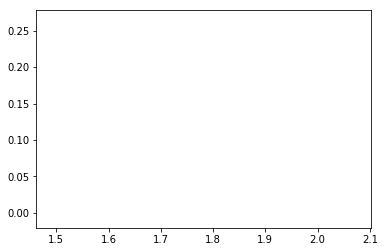

In [23]:
%matplotlib inline
for i in range(n_samples.get_value()):
    plt.plot(yObsM[i,:,0],yObsM[i,:,1])

In [24]:
gen = np.empty((n_samples.get_value()), dtype = str)
ald = np.zeros(n_samples.get_value())
for i in range(n_samples.get_value()):
    ald[i] = A['combined'][0,i][2][0]
    gen[i] = A['combined'][0,i][1][0][0]

xT0 = ald.reshape((n_samples.get_value(),mx.get_value()))

In [25]:
ui0 = np.linalg.lstsq(xT0, yObs)[0].flatten()
ui0 = ui0/np.linalg.norm(ui0)

x01 = np.zeros(mx.get_value())

/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [26]:
W0 = np.array([[np.linalg.norm(ui0)]])[0:mx.get_value(),0:mx.get_value()]
drift0 = np.array([0.01,0.01])[0:mx.get_value()]

tau0 = 0.1

y0 = np.mean(yObs, axis = 0)

para0 = np.hstack((tau0,drift0,W0.flatten(),y0.flatten(),ui0.flatten()))
print("Initial para = ", para0)

Initial para =  [0.1        0.01       1.         1.82520418 0.13137667 0.99760812
 0.06912331]


# Laplace Approximation:

### Optimal processes:

In [ ]:
dwtv = np.random.normal(0.0, dt.eval(), (n_samples.get_value(),n_steps.get_value(),mx.get_value()))

start = time.time()
print(M.hf(dwtv.flatten(),yObs,xT0,x01,para0))
diff = time.time() - start
print("time h = ", diff)

start = time.time()
print(M.logdethesshf(dwtv.flatten(),yObs,xT0,x01,para0))
diff = time.time() - start
print("time = ", diff)

In [ ]:
start = time.time()
dWtop = multprocdwt(para0,x01,yObs,xT0,n_pool=1)
diff = time.time() - start
print("time = ", diff)

In [ ]:
def multprocdwt(para,x0,y,xT,n_pool):
    
    dwt = np.zeros((y.shape[0],n_steps.get_value()))
    for i in range(y.shape[0]):
        dwt[i,:] = M.multprocdwti(para,x0,(y[i,:],xT[i,:]))
    #p = Pool(processes = n_pool)
    #sol = p.map(partial(M.multprocdwti,para,x0),\
    #                     mpu.inputArgs(y,xT),chunksize = n_samples.get_value()/n_pool)
    #res = list(sol)
    #p.terminate()
    
    return dwt#np.array(zip(res))

### Estimation:

In [ ]:
dwtv = np.random.normal(0.0, dt.eval(), (n_samples.get_value(),n_steps.get_value(),mx.get_value()))
start = time.time()
print("Initial likelihood = ", M.loglikef(para0,x01,yObs,xT0,dwtv.flatten()))
diff = time.time() - start
print("time = ", diff)

#start = time.time()
#print("Gradient = ", np.round(scipy.optimize.approx_fprime(para0,loglikef,0.001,x01,yObs,xT0,dWtop.flatten()),2)
#diff = (time.time() - start)/60
#print("time gradient = ", diff)

In [ ]:
paraEst = LapApprox(para0,10**(-4),300,0.2,x01,yObs,
                    xT0,dWtop.flatten())